# 2022-11-28

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from typing import List
import seaborn as sns
import eli5

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from eli5.sklearn import PermutationImportance

In [3]:
# Importing data

df = pd.read_csv("./data/titanic.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Check count of null values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# Removing almost empty feature

df.drop(columns=["Cabin"], axis=1, inplace=True)

In [117]:
df.dropna(subset=["Embarked"], inplace=True)

## EDA

In [10]:
df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [11]:
df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [42]:
# Filling missing age

df["Age"].fillna(df["Age"].mean(), inplace=True)

[]

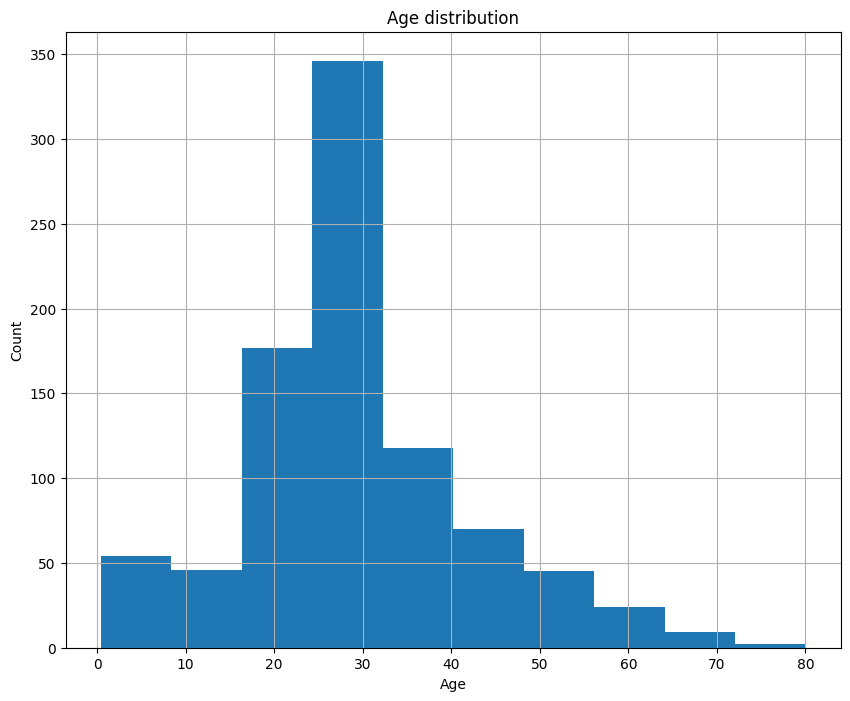

In [43]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
df[["Age"]].hist(ax=ax)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution")
plt.plot()

In [47]:
# Creating new age feature

df.loc[df["Age"] <= 14, "age_group"] = "child"
df.loc[(df["Age"] > 14) & (df["Age"] <= 55), "age_group"] = "adult"
df.loc[(df["Age"] > 55), "age_group"] = "elder"

In [48]:
df[["age_group", "Survived"]].groupby(["age_group"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,age_group,Survived
1,child,0.584416
0,adult,0.368217
2,elder,0.300000


In [49]:
# Checking how many boys vs girls survived
df.loc[df["age_group"] == "child"][["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.631579
1,male,0.538462


## Creating baseline

In [62]:
def person_survived(age_group: str, sex: str, pclass: int) -> int:
    if sex == "female" or pclass == 1 or age_group == "child":
        return 1
    return 0

prediction = df[["age_group", "Sex", "Pclass"]].apply(lambda x: person_survived(*x), axis=1)
true_label = df["Survived"]

print(classification_report(true_label, prediction))
print(f1_score(true_label, prediction))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77       549
           1       0.63      0.87      0.73       342

    accuracy                           0.75       891
   macro avg       0.76      0.77      0.75       891
weighted avg       0.79      0.75      0.75       891

0.7272727272727273


## Continue EDA

In [74]:
df.groupby(["Parch"]).count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Embarked,is_child,is_adult,is_elder,age_class,age_group,had_parch,had_sibsp,is_alone
Parch,,,,,,,,,,,,,,,,,,
0,678,678,678,678,678,678,678,678,678,676,678,678,678,678,678,678,678,678
1,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
2,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80
3,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [75]:
df.loc[df["age_group"] == "child"].groupby(["Parch"]).count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Embarked,is_child,is_adult,is_elder,age_class,age_group,had_parch,had_sibsp,is_alone
Parch,,,,,,,,,,,,,,,,,,
0,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
1,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
2,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33


In [76]:
df["had_parch"] = df["Parch"].apply(lambda x: int(x > 0))
df[["had_parch", "Survived"]].groupby(["had_parch"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,had_parch,Survived
1,1,0.511737
0,0,0.343658


In [77]:
df.groupby(["SibSp"]).count()

,PassengerId,Survived,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Embarked,is_child,is_adult,is_elder,age_class,age_group,had_parch,had_sibsp,is_alone
SibSp,,,,,,,,,,,,,,,,,,
0,608,608,608,608,608,608,608,608,608,606,608,608,608,608,608,608,608,608
1,209,209,209,209,209,209,209,209,209,209,209,209,209,209,209,209,209,209
2,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
3,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
4,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [80]:
df["had_sibsp"] = df["SibSp"].apply(lambda x: int(x > 0))
df[["had_sibsp", "Survived"]].groupby(["had_sibsp"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,had_sibsp,Survived
1,1,0.466431
0,0,0.345395


In [81]:
df["is_alone"] = (df["SibSp"] + df["Parch"]).apply(lambda x: int(x == 0))
df[["is_alone", "Survived"]].groupby(["is_alone"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,is_alone,Survived
0,0,0.505650
1,1,0.303538


In [82]:
df["Name"].head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [ ]:
def extract_name_info(full_name: str) -> str:
    sencod_half = full_name.split(",")[1]
    return sencod_half.split(".")[0].strip()

In [ ]:
extract_name_info("Williams, Mr. Charles Eugene")

In [89]:
df["name_info"] = df["Name"].apply(extract_name_info)

In [91]:
df.groupby(["name_info"]).count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,is_child,is_adult,is_elder,age_class,age_group,had_parch,had_sibsp,is_alone
name_info,,,,,,,,,,,,,,,,,,,
Capt,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Col,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Don,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Dr,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Jonkheer,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Lady,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Major,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Master,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
Miss,182,182,182,182,182,182,182,182,182,182,181,182,182,182,182,182,182,182,182


In [99]:
df[["name_info", "Survived"]].groupby(["name_info"], as_index=False).agg(["mean", "count"])

Survived      
                  mean count
name_info                   
Capt          0.000000     1
Col           0.500000     2
Don           0.000000     1
Dr            0.428571     7
Jonkheer      0.000000     1
Lady          1.000000     1
Major         0.500000     2
Master        0.575000    40
Miss          0.697802   182
Mlle          1.000000     2
Mme           1.000000     1
Mr            0.156673   517
Mrs           0.792000   125
Ms            1.000000     1
Rev           0.000000     6
Sir           1.000000     1
the Countess  1.000000     1

In [105]:
df["Fare"].head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

32.204207968574636


[]

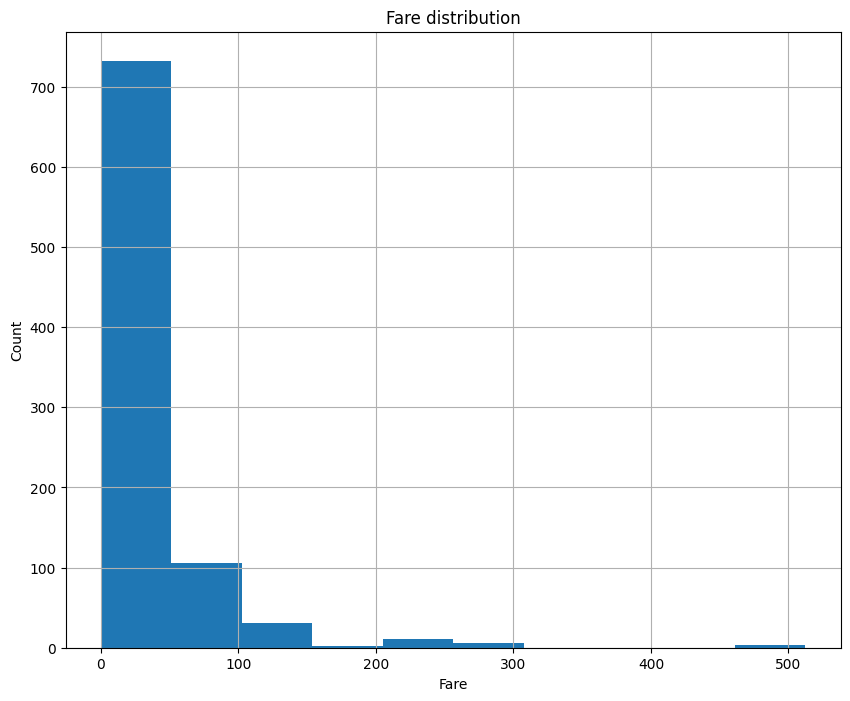

In [107]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
df[["Fare"]].hist(ax=ax)
print(df["Fare"].mean())
plt.xlabel("Fare")
plt.ylabel("Count")
plt.title("Fare distribution")
plt.plot()

In [112]:
df["ticket_is_expensive"] = df["Fare"].apply(lambda x: int(x > 50))
df[["ticket_is_expensive", "Survived"]].groupby(["ticket_is_expensive"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,ticket_is_expensive,Survived
1,1,0.681250
0,0,0.318741


In [118]:
df[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


## Better feature engineering

In [121]:
# Filling with better means

df.loc[df["name_info"] == "Miss"]["Age"] = df.loc[df["name_info"] == "Miss"]["Age"].mean()
df.loc[df["name_info"] == "Mrs"]["Age"] = df.loc[df["name_info"] == "Mrs"]["Age"].mean()

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_83417/2273486761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["name_info"] == "Miss"]["Age"] = df.loc[df["name_info"] == "Miss"]["Age"].mean()
/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_83417/2273486761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["name_info"] == "Mrs"]["Age"] = df.loc[df["name_info"] == "Mrs"]["Age"].mean()


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          889 non-null    int64  
 1   Survived             889 non-null    int64  
 2   Pclass               889 non-null    int64  
 3   Name                 889 non-null    object 
 4   Sex                  889 non-null    object 
 5   Age                  889 non-null    float64
 6   SibSp                889 non-null    int64  
 7   Parch                889 non-null    int64  
 8   Ticket               889 non-null    object 
 9   Fare                 889 non-null    float64
 10  Embarked             889 non-null    object 
 11  is_child             889 non-null    int64  
 12  is_adult             889 non-null    int64  
 13  is_elder             889 non-null    int64  
 14  age_class            889 non-null    object 
 15  age_group            889 non-null    obj

In [125]:
engineerd_features = ["ticket_is_expensive", "is_alone", "age_group"]

pd.get_dummies(df["age_group"])

,adult,child,elder
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
886,1,0,0
887,1,0,0
888,1,0,0
889,1,0,0


In [133]:
def engineer_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df["ticket_is_expensive"] = df["Fare"].apply(lambda x: int(x > 50))
    df["is_alone"] = (df["SibSp"] + df["Parch"]).apply(lambda x: int(x == 0))

    df["is_child"] = 0
    df["is_adult"] = 0
    df["is_elder"] = 0
    df.loc[df["Age"] <= 14, "is_child"] = 1
    df.loc[(df["Age"] > 14) & (df["Age"] <= 55), "is_adult"] = 1
    df.loc[(df["Age"] > 55), "is_elder"] = 1
    return df

In [141]:
def process_age(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df["name_info"] = df["Name"].apply(extract_name_info)

    df["Age"].fillna(df["Age"].mean())
    df.loc[df["name_info"] == "Miss"]["Age"] = df.loc[df["name_info"] == "Miss"]["Age"].mean()
    df.loc[df["name_info"] == "Mrs"]["Age"] = df.loc[df["name_info"] == "Mrs"]["Age"].mean()

    return df

In [186]:
def process_dataset(data: pd.DataFrame, label: str, categorical_features: List[str], continues_features: List[str]) -> pd.DataFrame:
    df = data.copy()
    df.drop(columns=list(set(df.columns) - set(continues_features + categorical_features + [label])), axis=1, inplace=True)
    for feature in categorical_features:
        dummies = pd.get_dummies(df[feature])
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=[feature], axis=1, inplace=True)
    return df

In [151]:
df1 = pd.read_csv("./data/titanic.csv")
df1 = engineer_features(df1)
df1 = process_age(df1)
df1 = process_dataset(df1, label="Survived", categorical_features=["Pclass", "Embarked", "Sex"], continues_features=["ticket_is_expensive", "is_alone", "is_child", "is_adult", "is_elder"])

df1.info()

Index(['Survived', 'Pclass', 'Sex', 'Embarked', 'ticket_is_expensive',
       'is_alone', 'is_child', 'is_adult', 'is_elder'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Survived             891 non-null    int64
 1   ticket_is_expensive  891 non-null    int64
 2   is_alone             891 non-null    int64
 3   is_child             891 non-null    int64
 4   is_adult             891 non-null    int64
 5   is_elder             891 non-null    int64
 6   1                    891 non-null    uint8
 7   2                    891 non-null    uint8
 8   3                    891 non-null    uint8
 9   C                    891 non-null    uint8
 10  Q                    891 non-null    uint8
 11  S                    891 non-null    uint8
 12  female               891 non-null    uint8
 13  male                 

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_83417/2053805420.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["name_info"] == "Miss"]["Age"] = df.loc[df["name_info"] == "Miss"]["Age"].mean()
/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_83417/2053805420.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["name_info"] == "Mrs"]["Age"] = df.loc[df["name_info"] == "Mrs"]["Age"].mean()


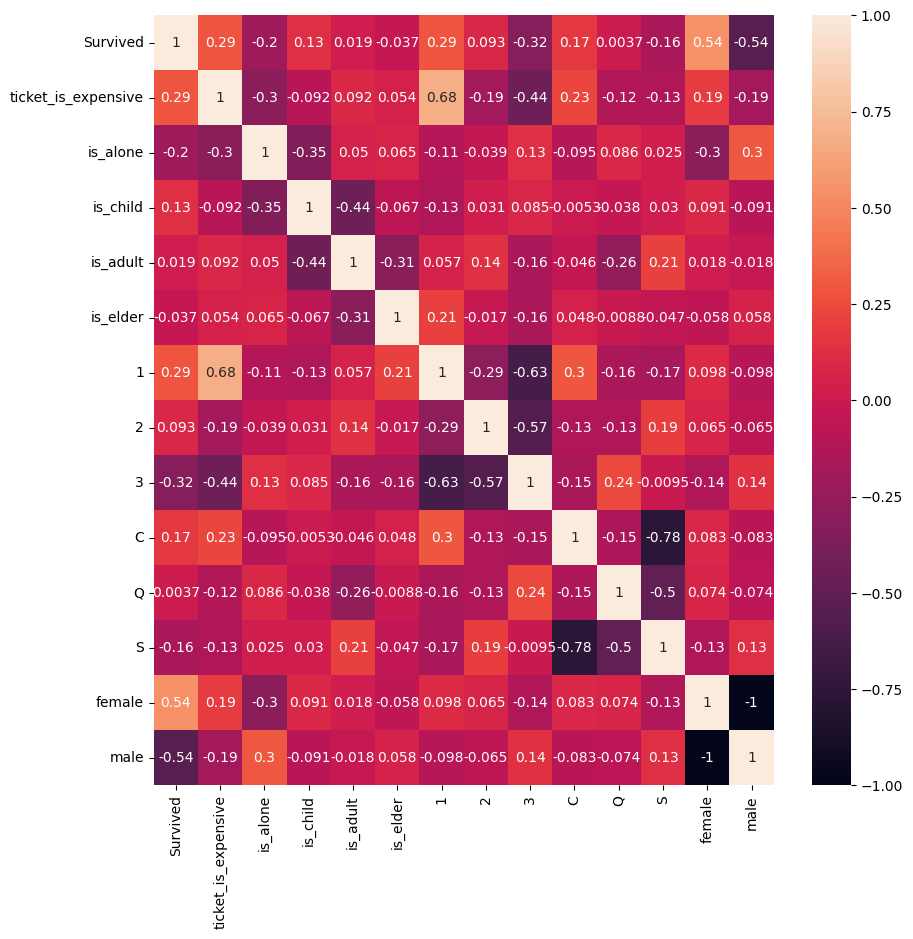

In [153]:
plt.figure(figsize=(10, 10))
corr = df1.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

## Modelling

In [211]:
data_df = pd.read_csv("./data/titanic_train.csv")

In [212]:
categorical_features=["Pclass", "Embarked", "Sex"]
continues_features=["ticket_is_expensive", "is_alone", "is_child", "is_adult", "is_elder"]
label = "Survived"

data_df = engineer_features(data_df)
data_df = process_age(data_df)
data_df = process_dataset(data_df, label=label, categorical_features=categorical_features, continues_features=continues_features)
data_df.dropna(inplace=True)

train_df, test_df = train_test_split(data_df, stratify=data_df[label].values)

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_83417/2053805420.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["name_info"] == "Miss"]["Age"] = df.loc[df["name_info"] == "Miss"]["Age"].mean()
/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_83417/2053805420.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["name_info"] == "Mrs"]["Age"] = df.loc[df["name_info"] == "Mrs"]["Age"].mean()


In [209]:
features = list(data_df.columns)
features.remove(label)

scaler = StandardScaler().fit(data_df[features].values)


x_train = scaler.transform(train_df[features].values)
x_test = scaler.transform(test_df[features].values)

y_train = train_df[label].values
y_test = test_df[label].values

In [213]:
lg = LogisticRegression()

lg.fit(x_train, y_train)

LogisticRegression()

In [224]:
# baseline performance

def person_survived(is_child: int, female: int, pclass_first: int) -> int:
    if female or pclass_first or is_child:
        return 1
    return 0

prediction = test_df[["is_child", "female", 1]].apply(lambda x: person_survived(*x), axis=1)

print(classification_report(y_test, prediction))
print(f1_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.62      0.52      0.56       137
           1       0.39      0.49      0.43        86

    accuracy                           0.51       223
   macro avg       0.50      0.50      0.50       223
weighted avg       0.53      0.51      0.51       223

0.43298969072164956


In [225]:
predictions = lg.predict(x_test)
print(classification_report(y_test, predictions))
print(f1_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       137
           1       0.78      0.66      0.72        86

    accuracy                           0.80       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.80      0.80      0.79       223

0.7169811320754716


In [229]:
perm = PermutationImportance(lg).fit(x_test, y_test)
eli5.show_weights(perm, feature_names=[str(i) for i in features])

Weight,Feature
0.0843 ± 0.0280,male
0.0798 ± 0.0347,female
0.0278 ± 0.0105,3
0.0215 ± 0.0192,S
0.0188 ± 0.0174,1
0.0117 ± 0.0091,is_alone
0.0090 ± 0.0098,ticket_is_expensive
0.0063 ± 0.0257,is_child
0.0036 ± 0.0105,is_adult
0.0036 ± 0.0105,2
